<h3>Path definition</h3>
Adjust the Path to your folder!

In [ ]:
import pandas as pd
from pathlib import Path

# === Pfad zur Datei ===
base_path = Path(r"C:\Users\samue\OneDrive - OST\Master_Mechatronics_Automation_OST\3_HS_Mechatronics_Automation_OST_2025\03_projektarbeit_ntu\80_Data\2025.09.10\sway")
file_path = base_path / "rosbag2_2025_09_10-10_14_36.csv"

# === Letzten Ordnernamen extrahieren ===
folder_name = base_path.name

<h3>Data Synchronizer</h3>

In [11]:
# === Read of original data ===
import numpy as np

print("CSV-Datei wird eingelesen...")
df = pd.read_csv(file_path)
print("Anzahl Zeilen im Original:", len(df))
df.head()

# Filter: nur Zeilen mit thrusters_states.data oder sbs.distance_1
mask_thrusters = df["thrusters_states.data"].notna()
mask_sonar = df["sbs.distance_1"].notna()

# Gefilterte Zeilen
df_filtered = df[mask_thrusters | mask_sonar].copy()
print("Anzahl Zeilen nach Filterung:", len(df_filtered))

# === Sensorzeit berechnen (nur bei Sonar gültig) ===
df_filtered["sensor_time"] = (
    df_filtered["sbs.header.stamp.sec"].fillna(0).astype("Int64") +
    df_filtered["sbs.header.stamp.nanosec"].fillna(0).astype("Int64") / 1e9
)

# Maske für Zeilen mit Sonardaten
mask_sonar = df_filtered["sbs.distance_1"].notna() & df_filtered["sensor_time"].notna()

# X = globale Zeit (immer vorhanden), Y = Sensorzeit (nur bei Sonar)
x_known = df_filtered.loc[mask_sonar, "t_sec"].astype(float).to_numpy()
y_known = df_filtered.loc[mask_sonar, "sensor_time"].astype(float).to_numpy()

# Gesamte Zeitachse interpolieren
x_all = df_filtered["t_sec"].astype(float).to_numpy()
syn_time = np.interp(x_all, x_known, y_known)

df_filtered["syn.time.stamp"] = syn_time

# === Zielspalten definieren (Basis) ===
target_columns = [
    "t_sec",
    "syn.time.stamp",
    "sbs.distance_1", "sbs.distance_2", "sbs.distance_3",
    "thrusters_states.data"
]

for col in target_columns:
    if col not in df_filtered.columns:
        df_filtered[col] = np.nan

df_merged = df_filtered[target_columns].copy()

# === Thruster-Digits in Kräfte umrechnen ===
ALL_THRUSTERS = ["vt1_N","vt2_N","vt3_N","vt4_N", "ht1_N","ht2_N","ht3_N","ht4_N"]

digit_to_force = {"1": 0.0, "2": 4.7, "3": -4.7}

# Spalten initialisieren mit NaN
for thr in ALL_THRUSTERS:
    df_merged[thr] = np.nan

def decode_thrusters(val):
    if pd.isna(val):
        return [np.nan]*8
    digits = list(str(int(val)))
    digits = ["1"]*(8-len(digits)) + digits  # auffüllen mit '1' (=0N)
    return [digit_to_force.get(d, np.nan) for d in digits]

thruster_forces = df_merged["thrusters_states.data"].apply(decode_thrusters)
thruster_forces = np.array(thruster_forces.tolist())

for i, thr in enumerate(ALL_THRUSTERS):
    df_merged[thr] = thruster_forces[:, i]

# === Gesamtkraft berechnen NUR für Zeilen mit Thruster-State ===
mask_thrusters = df_merged["thrusters_states.data"].notna()

df_merged.loc[mask_thrusters, "heave_total"] = (
    df_merged.loc[mask_thrusters, ["vt1_N","vt2_N","vt3_N","vt4_N"]].sum(axis=1)
)

df_merged.loc[mask_thrusters, "heave_total"] = (
     df_merged.loc[mask_thrusters, "vt1_N"] -
     df_merged.loc[mask_thrusters, "vt2_N"] -
     df_merged.loc[mask_thrusters, "vt3_N"] +
     df_merged.loc[mask_thrusters, "vt4_N"]
)

df_merged.loc[mask_thrusters, "surge_total"] = (np.sqrt(2)/2) * (
     df_merged.loc[mask_thrusters, "ht1_N"] -
     df_merged.loc[mask_thrusters, "ht2_N"] +
     df_merged.loc[mask_thrusters, "ht3_N"] -
     df_merged.loc[mask_thrusters, "ht4_N"]
)

df_merged.loc[mask_thrusters, "sway_total"] = (np.sqrt(2)/2) * (
     df_merged.loc[mask_thrusters, "ht1_N"] +
     df_merged.loc[mask_thrusters, "ht2_N"] -
     df_merged.loc[mask_thrusters, "ht3_N"] -
     df_merged.loc[mask_thrusters, "ht4_N"]
)

# === Bewegungsrichtung bestimmen NUR für Thruster-Zeilen ===
def motion_type(row):
    if pd.isna(row["thrusters_states.data"]):
        return np.nan
    if row["heave_total"] != 0:
        return "heave"
    elif row["surge_total"] != 0:
        return "surge"
    elif row["sway_total"] != 0:
        return "sway"
    else:
        return "none"

df_merged["motion_type"] = df_merged.apply(motion_type, axis=1)

# === Speichern ===
output_path = file_path.with_name(file_path.stem + "_m.csv")
df_merged.to_csv(output_path, index=False)

print("Neue Datei gespeichert unter:", output_path)

CSV-Datei wird eingelesen...
Anzahl Zeilen im Original: 2808
Anzahl Zeilen nach Filterung: 1022
Neue Datei gespeichert unter: C:\Users\samue\OneDrive - OST\Master_Mechatronics_Automation_OST\3_HS_Mechatronics_Automation_OST_2025\03_projektarbeit_ntu\80_Data\2025.09.10\surge\rosbag2_2025_09_10-10_12_02_m.csv


In [12]:
# === Read of filtered data (_f) ===
import numpy as np

print("CSV-Datei wird eingelesen (_f)...")
file_f = file_path.with_name(file_path.stem + "_f.csv")
df = pd.read_csv(file_f)
print("Anzahl Zeilen im Original (_f):", len(df))
df.head()

# === Masken für die gewünschten Topics ===
mask_sonar = df["SONAR_raw.distance_1"].notna()
mask_vel   = df["SONAR_vel.vector.x"].notna()
mask_pose  = df["Pose.pose.position.x"].notna()

# Gefilterte Zeilen
df_filtered = df[mask_sonar | mask_vel | mask_pose].copy()
print("Anzahl Zeilen nach Filterung (_f):", len(df_filtered))

# === Sensorzeit berechnen (nur bei Sonar gültig) ===
df_filtered["sensor_time"] = (
    df_filtered["SONAR_raw.header.stamp.sec"].fillna(0).astype("Int64") +
    df_filtered["SONAR_raw.header.stamp.nanosec"].fillna(0).astype("Int64") / 1e9
)

# Maske für Zeilen mit Sonardaten
mask_sonar = df_filtered["SONAR_raw.distance_1"].notna() & df_filtered["sensor_time"].notna()

# X = globale Zeit, Y = Sensorzeit (nur bei Sonar gültig)
x_known = df_filtered.loc[mask_sonar, "t_sec"].astype(float).to_numpy()
y_known = df_filtered.loc[mask_sonar, "sensor_time"].astype(float).to_numpy()

# Gesamte Zeitachse interpolieren
x_all = df_filtered["t_sec"].astype(float).to_numpy()
syn_time = np.interp(x_all, x_known, y_known)

df_filtered["syn.time.stamp"] = syn_time

# === Zielspalten definieren ===
target_columns = [
    "t_sec",
    "syn.time.stamp",
    "SONAR_raw.distance_1", "SONAR_raw.distance_2", "SONAR_raw.distance_3",
    "SONAR_vel.vector.x", "SONAR_vel.vector.y", "SONAR_vel.vector.z",
    "Pose.pose.position.x", "Pose.pose.position.y", "Pose.pose.position.z"
]

for col in target_columns:
    if col not in df_filtered.columns:
        df_filtered[col] = np.nan

df_merged = df_filtered[target_columns].copy()

# === Speichern ===
output_path = file_path.with_name(file_path.stem + "_fm.csv")
df_merged.to_csv(output_path, index=False)

print("Neue Datei gespeichert unter:", output_path)


CSV-Datei wird eingelesen (_f)...
Anzahl Zeilen im Original (_f): 8465
Anzahl Zeilen nach Filterung (_f): 1933
Neue Datei gespeichert unter: C:\Users\samue\OneDrive - OST\Master_Mechatronics_Automation_OST\3_HS_Mechatronics_Automation_OST_2025\03_projektarbeit_ntu\80_Data\2025.09.10\surge\rosbag2_2025_09_10-10_12_02_fm.csv


In [13]:
# === Synchronisation der _m und _fm Dateien => sync ===
print("Starte Synchronisation...")

# Eingangsdateien
file_m  = file_path.with_name(file_path.stem + "_m.csv")
file_fm = file_path.with_name(file_path.stem + "_fm.csv")

df_m  = pd.read_csv(file_m)
df_fm = pd.read_csv(file_fm)

print("Zeilen _m:", len(df_m), " | Zeilen _fm:", len(df_fm))

# Zusammenführen über syn.time.stamp
df_sync = pd.merge(
    df_m, df_fm,
    on="syn.time.stamp", 
    how="outer", 
    suffixes=("_m", "_fm")
)

# Nach Zeit sortieren
df_sync = df_sync.sort_values("syn.time.stamp").reset_index(drop=True)

# Doppelte Zeitstempel entfernen
df_sync = df_sync.drop_duplicates(subset=["syn.time.stamp"])

# Globale Zeitangaben entfernen (t_sec* und t_nsec*)
cols_to_drop = [c for c in df_sync.columns if c.startswith("t_sec") or c.startswith("t_nsec")]
df_sync = df_sync.drop(columns=cols_to_drop, errors="ignore")

# Speichern
output_path_sync = file_path.with_name(file_path.stem + "_sync.csv")
df_sync.to_csv(output_path_sync, index=False)

print("Synchronisierte Datei gespeichert unter:", output_path_sync)

# Vorschau
df_sync.head()


Starte Synchronisation...
Zeilen _m: 1022  | Zeilen _fm: 1933
Synchronisierte Datei gespeichert unter: C:\Users\samue\OneDrive - OST\Master_Mechatronics_Automation_OST\3_HS_Mechatronics_Automation_OST_2025\03_projektarbeit_ntu\80_Data\2025.09.10\surge\rosbag2_2025_09_10-10_12_02_sync.csv


,syn.time.stamp,sbs.distance_1,sbs.distance_2,sbs.distance_3,thrusters_states.data,vt1_N,vt2_N,vt3_N,vt4_N,ht1_N,...,motion_type,SONAR_raw.distance_1,SONAR_raw.distance_2,SONAR_raw.distance_3,SONAR_vel.vector.x,SONAR_vel.vector.y,SONAR_vel.vector.z,Pose.pose.position.x,Pose.pose.position.y,Pose.pose.position.z
0,1.757470e+09,NaN,NaN,NaN,11111111.0,0.0,0.0,0.0,0.0,0.0,...,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,1.757470e+09,NaN,NaN,NaN,11111111.0,0.0,0.0,0.0,0.0,0.0,...,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,1.757470e+09,NaN,NaN,NaN,11111111.0,0.0,0.0,0.0,0.0,0.0,...,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,1.757470e+09,NaN,NaN,NaN,11111111.0,0.0,0.0,0.0,0.0,0.0,...,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78,1.757470e+09,NaN,NaN,NaN,11111111.0,0.0,0.0,0.0,0.0,0.0,...,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h3>Data Selection</h3>

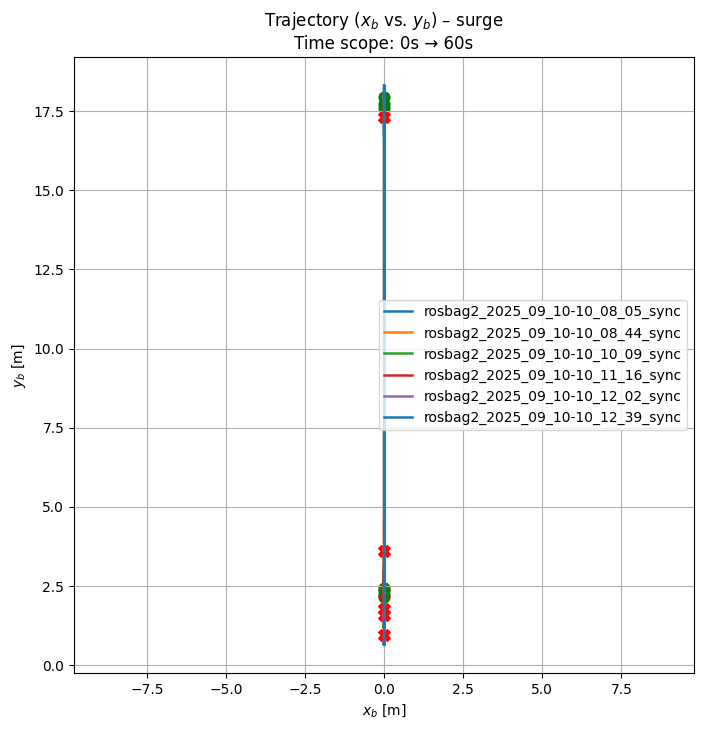

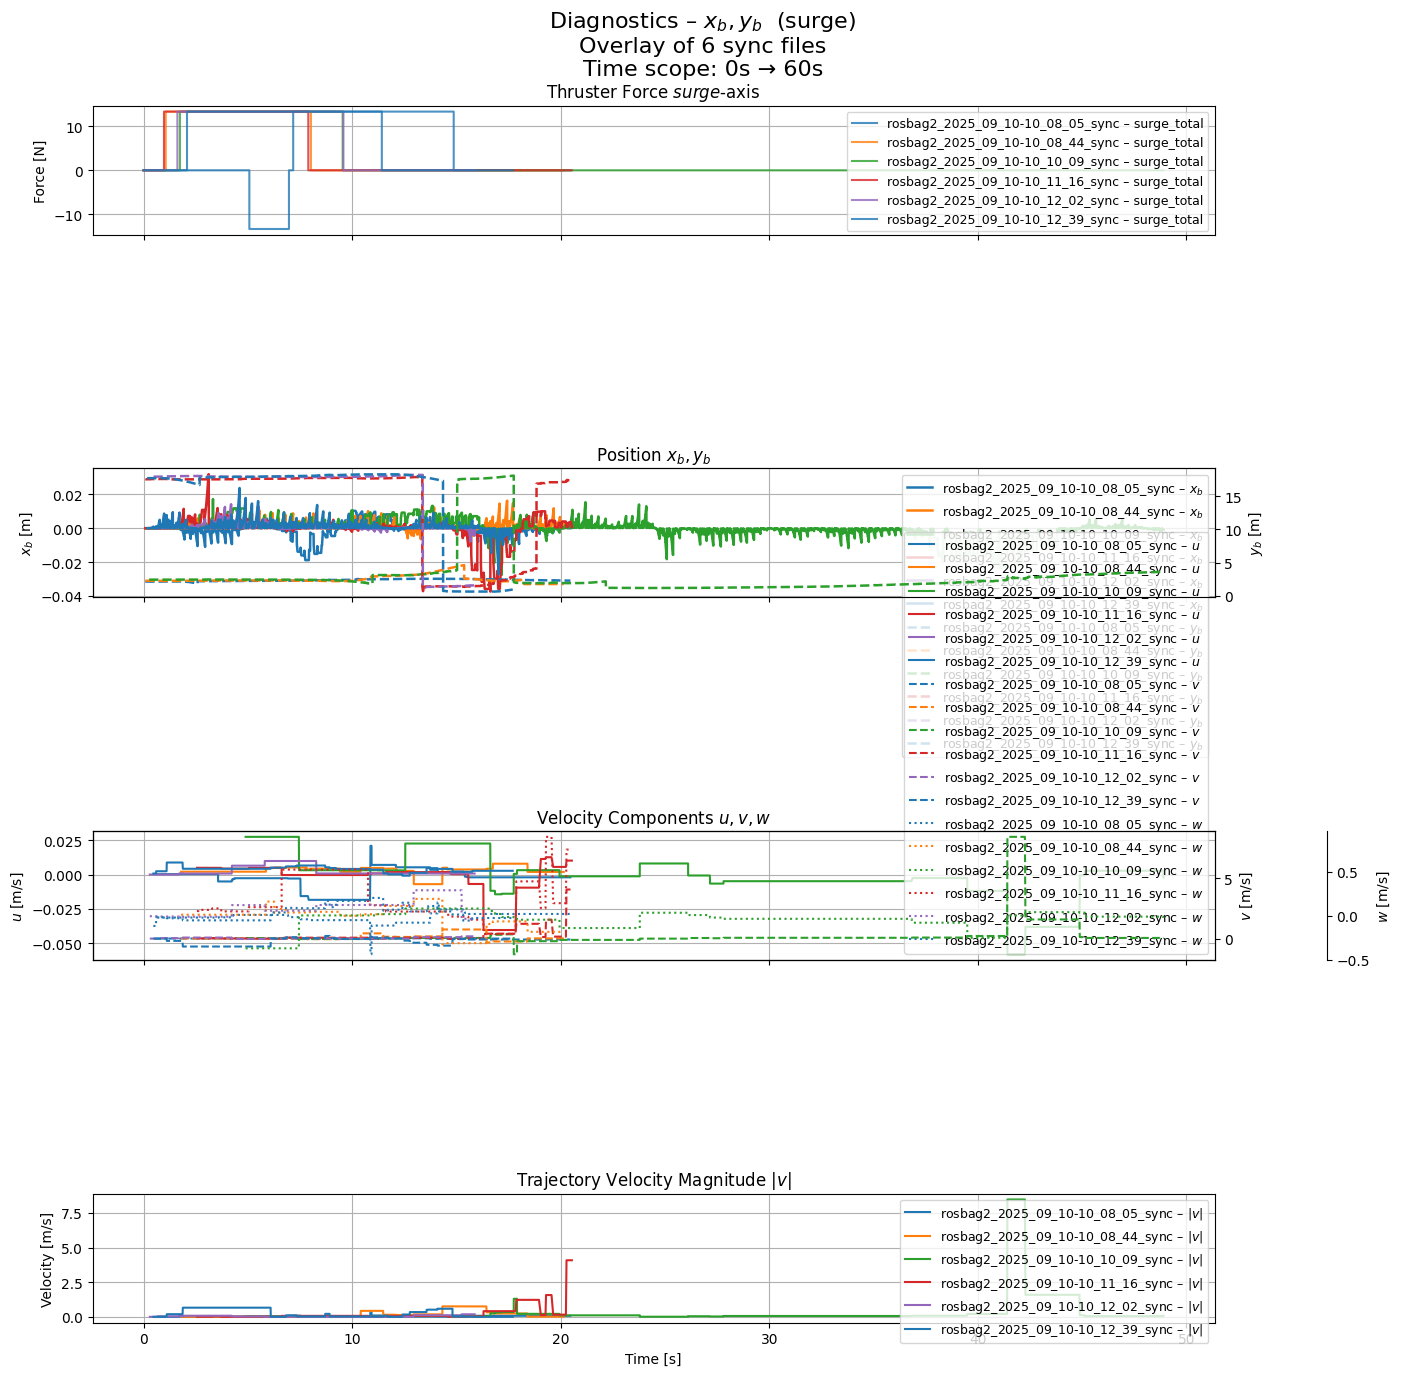

In [14]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# === Setup ===
base_path = Path(r"C:\Users\samue\OneDrive - OST\Master_Mechatronics_Automation_OST\3_HS_Mechatronics_Automation_OST_2025\03_projektarbeit_ntu\80_Data\2025.09.10\surge")

folder_name = base_path.name.lower()      # e.g. "heave"
mode = "pose"                             # "sonar_raw", "sonar_filtered", or "pose"
t_start, t_end = 0, 60                   # seconds

# --- Axis labels and columns based on dataset ---
if folder_name == "heave":
    x_label_symbol, y_label_symbol = "z_b", "y_b"
    dist_x_col, dist_y_col, thruster_col = "Pose.pose.position.z", "Pose.pose.position.y", "heave_total"
elif folder_name == "surge":
    x_label_symbol, y_label_symbol = "x_b", "y_b"
    dist_x_col, dist_y_col, thruster_col = "Pose.pose.position.x", "Pose.pose.position.y", "surge_total"
elif folder_name == "sway":
    x_label_symbol, y_label_symbol = "x_b", "y_b"
    dist_x_col, dist_y_col, thruster_col = "Pose.pose.position.x", "Pose.pose.position.y", "sway_total"
else:
    x_label_symbol, y_label_symbol = "x_b", "y_b"
    dist_x_col, dist_y_col, thruster_col = "Pose.pose.position.x", "Pose.pose.position.y", None

# ====== XY TRAJECTORY PLOT ======
sync_files = list(base_path.glob("*_sync.csv"))
base_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

plt.figure(figsize=(8, 8))
for i, file in enumerate(sync_files):
    color = base_colors[i % len(base_colors)]
    df = pd.read_csv(file).sort_values("syn.time.stamp").ffill()
    df["time_norm"] = df["syn.time.stamp"] - df["syn.time.stamp"].iloc[0]
    df = df[(df["time_norm"] >= t_start) & (df["time_norm"] <= t_end)]

    if not {dist_x_col, dist_y_col}.issubset(df.columns):
        continue
    x, y = df[dist_x_col].dropna(), df[dist_y_col].dropna()
    if x.empty or y.empty:
        continue

    plt.plot(x, y, color=color, lw=1.8, label=file.stem)
    plt.scatter(x.iloc[0], y.iloc[0], color="green", marker="o", s=60, label="_nolegend_")
    plt.scatter(x.iloc[-1], y.iloc[-1], color="red", marker="X", s=70, label="_nolegend_")

plt.title(f"Trajectory ($ {x_label_symbol}$ vs. $ {y_label_symbol}$) – {folder_name}\nTime scope: {t_start}s → {t_end}s")
plt.xlabel(f"$ {x_label_symbol} $ [m]")
plt.ylabel(f"$ {y_label_symbol} $ [m]")
plt.axis("equal")
plt.grid(True)
plt.legend()
plt.show()

# ====== DIAGNOSTICS MULTIPANEL ======
fig, axes = plt.subplots(4, 1, figsize=(14, 14), sharex=True)
fig.suptitle(
    f"Diagnostics – $ {x_label_symbol}, {y_label_symbol} $  ({folder_name})\n"
    f"Overlay of {len(sync_files)} sync files\n"
    f"Time scope: {t_start}s → {t_end}s", fontsize=16
)

# Dual y-axis for position subplot
ax_pos_left = axes[1]
ax_pos_right = ax_pos_left.twinx()

for i, file in enumerate(sync_files):
    color = base_colors[i % len(base_colors)]
    df = pd.read_csv(file).sort_values("syn.time.stamp").ffill()
    df["time_norm"] = df["syn.time.stamp"] - df["syn.time.stamp"].iloc[0]
    df = df[(df["time_norm"] >= t_start) & (df["time_norm"] <= t_end)]

    # === 1) Thruster ===
    if thruster_col and thruster_col in df.columns:
        axes[0].step(df["time_norm"], df[thruster_col], where="post",
                     color=color, lw=1.5, alpha=0.8, label=f"{file.stem} – {thruster_col}")
    axes[0].set_title(f"Thruster Force $ {folder_name} $-axis")
    axes[0].set_ylabel("Force [N]")
    axes[0].grid(True)

    # === 2) Position (solid = z/x, dashed = y) ===
    if dist_x_col in df.columns:
        ax_pos_left.plot(df["time_norm"], df[dist_x_col],
                         color=color, lw=1.8, linestyle="-",
                         label=f"{file.stem} – $ {x_label_symbol} $")
    if dist_y_col in df.columns:
        ax_pos_right.plot(df["time_norm"], df[dist_y_col],
                          color=color, lw=1.8, linestyle="--",
                          label=f"{file.stem} – $ {y_label_symbol} $")

# Position axes styling
ax_pos_left.set_ylabel(f"$ {x_label_symbol} $ [m]", color="black")
ax_pos_right.set_ylabel(f"$ {y_label_symbol} $ [m]", color="black")
ax_pos_left.tick_params(axis="y", labelcolor="black")
ax_pos_right.tick_params(axis="y", labelcolor="black")
ax_pos_left.set_title(f"Position $ {x_label_symbol}, {y_label_symbol} $")
ax_pos_left.grid(True)

# === 3) Velocity (u, v, w) with 3 black axes ===
ax_v1 = axes[2]
ax_v2 = ax_v1.twinx()
ax_v3 = ax_v1.twinx()

# Offset the third axis to the right
ax_v3.spines["right"].set_position(("axes", 1.1))

for i, file in enumerate(sync_files):
    color = base_colors[i % len(base_colors)]
    df = pd.read_csv(file).sort_values("syn.time.stamp").ffill()
    df["time_norm"] = df["syn.time.stamp"] - df["syn.time.stamp"].iloc[0]
    df = df[(df["time_norm"] >= t_start) & (df["time_norm"] <= t_end)]

    if "SONAR_vel.vector.x" in df.columns:
        ax_v1.plot(df["time_norm"], df["SONAR_vel.vector.x"],
                   linestyle="-", color=color, lw=1.5, label=f"{file.stem} – $u$")
    if "SONAR_vel.vector.y" in df.columns:
        ax_v2.plot(df["time_norm"], df["SONAR_vel.vector.y"],
                   linestyle="--", color=color, lw=1.5, label=f"{file.stem} – $v$")
    if "SONAR_vel.vector.z" in df.columns:
        ax_v3.plot(df["time_norm"], df["SONAR_vel.vector.z"],
                   linestyle=":", color=color, lw=1.5, label=f"{file.stem} – $w$")

# Style all velocity axes black
for ax in [ax_v1, ax_v2, ax_v3]:
    ax.tick_params(axis="y", labelcolor="black")
    ax.yaxis.label.set_color("black")

ax_v1.set_ylabel("$u$ [m/s]", color="black")
ax_v2.set_ylabel("$v$ [m/s]", color="black")
ax_v3.set_ylabel("$w$ [m/s]", color="black")
ax_v1.set_title("Velocity Components $u, v, w$")
ax_v1.grid(True)

# Combine legends from all three
lines, labels = [], []
for ax in [ax_v1, ax_v2, ax_v3]:
    l, lab = ax.get_legend_handles_labels()
    lines += l
    labels += lab
ax_v1.legend(lines, labels, fontsize=9, loc="best")

# === 4) Trajectory Velocity Magnitude ===
for i, file in enumerate(sync_files):
    color = base_colors[i % len(base_colors)]
    df = pd.read_csv(file).sort_values("syn.time.stamp").ffill()
    df["time_norm"] = df["syn.time.stamp"] - df["syn.time.stamp"].iloc[0]
    df = df[(df["time_norm"] >= t_start) & (df["time_norm"] <= t_end)]
    if "SONAR_vel.vector.x" in df.columns and "SONAR_vel.vector.y" in df.columns:
        vx = df["SONAR_vel.vector.x"].to_numpy()
        vy = df["SONAR_vel.vector.y"].to_numpy()
        v_mag = np.sqrt(vx**2 + vy**2)
        axes[3].plot(df["time_norm"], v_mag, color=color, lw=1.5, label=f"{file.stem} – $|v|$")
axes[3].set_title("Trajectory Velocity Magnitude $|v|$")
axes[3].set_xlabel("Time [s]")
axes[3].set_ylabel("Velocity [m/s]")
axes[3].grid(True)
axes[3].legend(fontsize=9, loc="best")

# === Legends ===
axes[0].legend(fontsize=9, loc="best")
lines_l, labels_l = ax_pos_left.get_legend_handles_labels()
lines_r, labels_r = ax_pos_right.get_legend_handles_labels()
ax_pos_left.legend(lines_l + lines_r, labels_l + labels_r, fontsize=9, loc="best")

plt.tight_layout()
plt.show()


<h3>Data Scoping</h3>

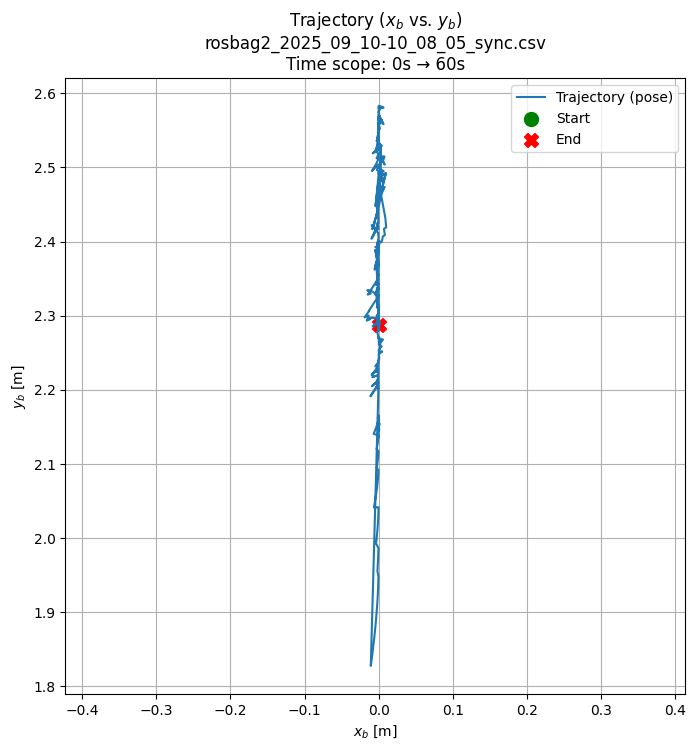

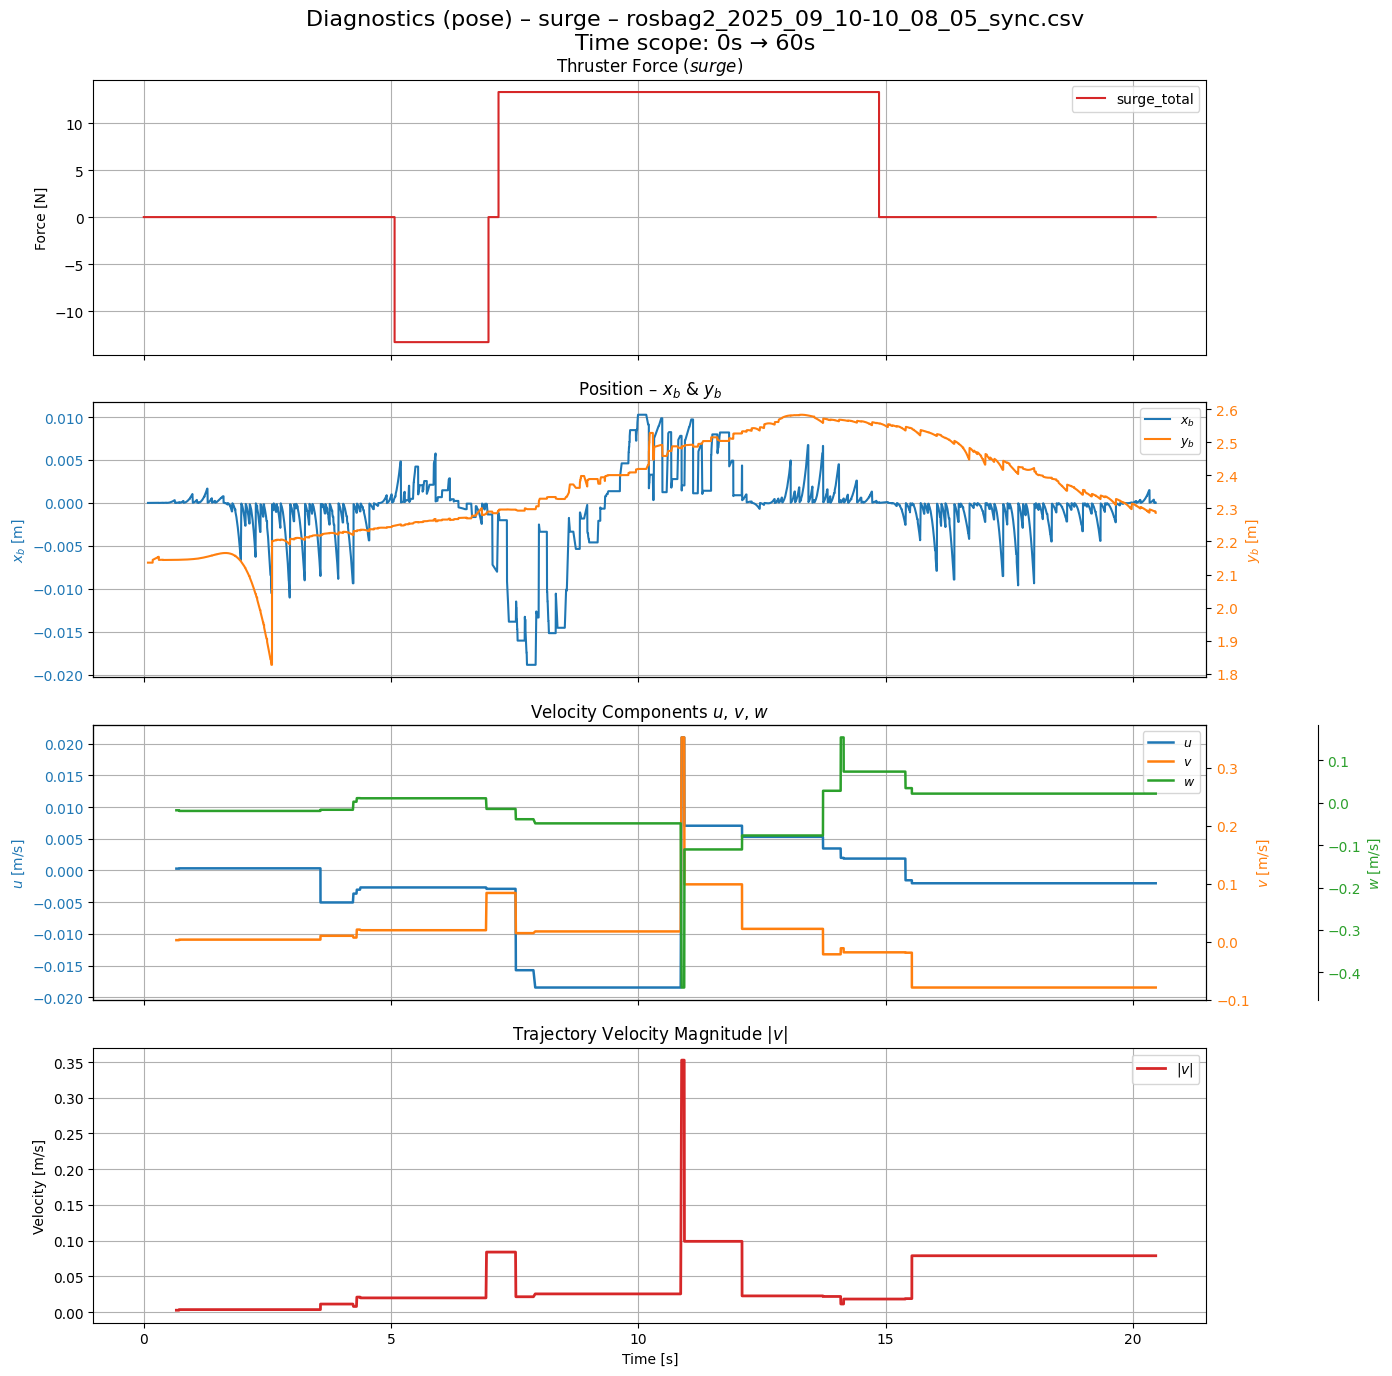

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# === INPUTS ===
base_path = Path(r"C:\Users\samue\OneDrive - OST\Master_Mechatronics_Automation_OST\3_HS_Mechatronics_Automation_OST_2025\03_projektarbeit_ntu\80_Data\2025.09.10\surge")
filename = "rosbag2_2025_09_10-10_08_05_sync.csv"
file_path = base_path / filename

# Choose data source
source = "pose"   # "raw" | "filtered" | "pose"

# Time window
t_start = 0
t_end   = 60

# === Folder-based axis & column selection ===
folder_name = base_path.name.lower()
if folder_name == "heave":
    x_label_symbol, y_label_symbol = "z_b", "y_b"
    dist_x_col, dist_y_col, thruster_col = "Pose.pose.position.z", "Pose.pose.position.y", "heave_total"
elif folder_name == "surge":
    x_label_symbol, y_label_symbol = "x_b", "y_b"
    dist_x_col, dist_y_col, thruster_col = "Pose.pose.position.x", "Pose.pose.position.y", "surge_total"
elif folder_name == "sway":
    x_label_symbol, y_label_symbol = "x_b", "y_b"
    dist_x_col, dist_y_col, thruster_col = "Pose.pose.position.x", "Pose.pose.position.y", "sway_total"
else:
    x_label_symbol, y_label_symbol = "x_b", "y_b"
    dist_x_col, dist_y_col, thruster_col = "Pose.pose.position.x", "Pose.pose.position.y", None

# === Load data ===
df_plot = pd.read_csv(file_path).sort_values("syn.time.stamp").ffill()
df_plot["time_norm"] = df_plot["syn.time.stamp"] - df_plot["syn.time.stamp"].iloc[0]
df_plot = df_plot[(df_plot["time_norm"] >= t_start) & (df_plot["time_norm"] <= t_end)]

# Convert mm→m for sonar
if source in ["raw", "filtered"]:
    for col in [dist_x_col, dist_y_col]:
        if col in df_plot.columns:
            df_plot[col] /= 1000.0

# === XY trajectory ===
plt.figure(figsize=(8, 8))
x = df_plot[dist_x_col]
y = df_plot[dist_y_col]
plt.plot(x, y, label=f"Trajectory ({source})", color="tab:blue")
if not x.empty:
    plt.scatter(x.iloc[0], y.iloc[0], color="green", marker="o", s=100, label="Start")
    plt.scatter(x.iloc[-1], y.iloc[-1], color="red", marker="X", s=100, label="End")

plt.title(f"Trajectory ($ {x_label_symbol}$ vs. $ {y_label_symbol}$)\n{filename}\nTime scope: {t_start}s → {t_end}s")
plt.xlabel(f"$ {x_label_symbol} $ [m]")
plt.ylabel(f"$ {y_label_symbol} $ [m]")
plt.axis("equal")
plt.legend()
plt.grid(True)
plt.show()

# === Velocity components ===
for comp, col in zip(["x", "y", "z"], ["SONAR_vel.vector.x", "SONAR_vel.vector.y", "SONAR_vel.vector.z"]):
    if col not in df_plot.columns:
        df_plot[col] = np.nan

df_plot["vel_mag"] = np.sqrt(df_plot["SONAR_vel.vector.x"]**2 + df_plot["SONAR_vel.vector.y"]**2)

# === Multi-panel plots ===
fig, axes = plt.subplots(4, 1, figsize=(14, 14), sharex=True)
fig.suptitle(f"Diagnostics ({source}) – {folder_name} – {filename}\nTime scope: {t_start}s → {t_end}s", fontsize=16)

# 1) Thruster
if thruster_col and thruster_col in df_plot.columns:
    axes[0].step(df_plot["time_norm"], df_plot[thruster_col], where="post", color="tab:red", label=thruster_col)
axes[0].set_title(f"Thruster Force ($ {folder_name} $)")
axes[0].set_ylabel("Force [N]")
axes[0].legend()
axes[0].grid(True)

# 2) Position with dual colored axes
ax_pos = axes[1]
line_x, = ax_pos.plot(df_plot["time_norm"], df_plot[dist_x_col],
                      color="tab:blue", label=f"$ {x_label_symbol} $")
ax_pos2 = ax_pos.twinx()
line_y, = ax_pos2.plot(df_plot["time_norm"], df_plot[dist_y_col],
                       color="tab:orange", label=f"$ {y_label_symbol} $")

ax_pos.set_ylabel(f"$ {x_label_symbol} $ [m]", color="tab:blue")
ax_pos2.set_ylabel(f"$ {y_label_symbol} $ [m]", color="tab:orange")
ax_pos.tick_params(axis="y", labelcolor="tab:blue")
ax_pos2.tick_params(axis="y", labelcolor="tab:orange")
ax_pos.set_title(f"Position – $ {x_label_symbol}$ & $ {y_label_symbol}$")
ax_pos.grid(True)

lines = [line_x, line_y]
labels = [l.get_label() for l in lines]
ax_pos.legend(lines, labels, fontsize=9, loc="best")

# 3) Velocity components u, v, w (three colored axes)
ax_v1 = axes[2]
ax_v2 = ax_v1.twinx()
ax_v3 = ax_v1.twinx()
ax_v3.spines["right"].set_position(("axes", 1.1))

ax_v1.plot(df_plot["time_norm"], df_plot["SONAR_vel.vector.x"], color="tab:blue", lw=1.8, label="$u$")
ax_v2.plot(df_plot["time_norm"], df_plot["SONAR_vel.vector.y"], color="tab:orange", lw=1.8, label="$v$")
ax_v3.plot(df_plot["time_norm"], df_plot["SONAR_vel.vector.z"], color="tab:green", lw=1.8, label="$w$")

ax_v1.set_ylabel("$u$ [m/s]", color="tab:blue")
ax_v2.set_ylabel("$v$ [m/s]", color="tab:orange")
ax_v3.set_ylabel("$w$ [m/s]", color="tab:green")
for ax in [ax_v1, ax_v2, ax_v3]:
    ax.tick_params(axis="y", labelcolor=ax.yaxis.label.get_color())

ax_v1.set_title("Velocity Components $u$, $v$, $w$")
ax_v1.grid(True)

# Combine legends
lines, labels = [], []
for ax in [ax_v1, ax_v2, ax_v3]:
    l, lab = ax.get_legend_handles_labels()
    lines += l
    labels += lab
ax_v1.legend(lines, labels, fontsize=9, loc="best")

# 4) Velocity magnitude
axes[3].plot(df_plot["time_norm"], df_plot["vel_mag"], color="tab:red", lw=2, label="$|v|$")
axes[3].set_title("Trajectory Velocity Magnitude $|v|$")
axes[3].set_xlabel("Time [s]")
axes[3].set_ylabel("Velocity [m/s]")
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.show()


C:\Users\samue\AppData\Local\Temp\ipykernel_18880\1552083298.py:129: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_pt2, _ = curve_fit(pt2_velocity, t, v, p0=p0_pt2, maxfev=20000)


=== $v(t)$ [m/s] Fit Results ===
PT2 Model:
  K   = 0.4692
  ωₙ  = 1.1210 rad/s
  ζ   = 1.0000
  t₀  = 15.0661 s

Exponential Model:
  K   = 0.6947
  τ   = 3.1147 s
  t₀  = 15.4123 s
  off = 0.0186

[Skip] 'x': Länge 2801 passt nicht zu len(t)=290.
[Displacement] Quelle: 'y' -> Spalte 'displacement_m'
[Excel] Wrote C:\Users\samue\Downloads\curvefit_rosbag2_2025_09_10-10_10_09_sync_Sway_20251103-221409.xlsx (engine='openpyxl')


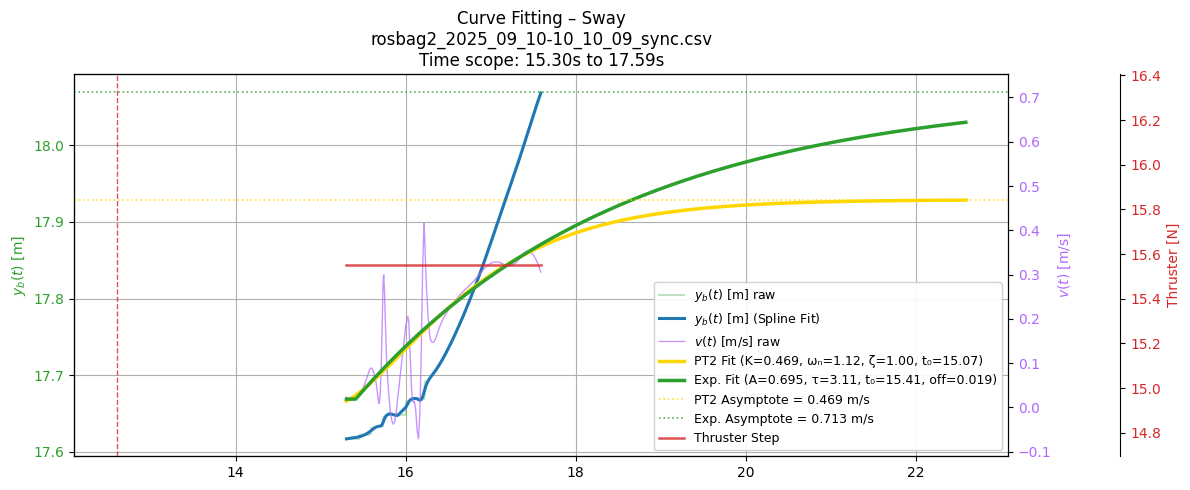

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit
from pathlib import Path

# === INPUTS ===
#base_path = Path(r"C:\Users\samue\OneDrive - OST\Master_Mechatronics_Automation_OST\3_HS_Mechatronics_Automation_OST_2025\03_projektarbeit_ntu\80_Data\2025.09.10\surge")
filename = "rosbag2_2025_09_10-10_10_09_sync.csv"
file_path = base_path / filename

mode = "y"             
# "x","y","z" → position-based | "u","v","w","mag" → velocity-base
t_start = 15.3
t_end   = 17.6



# === Manual Thruster Parameters (used if no *_total column exists) ===
thruster_level = 15.55    # [N]
thruster_x     = 12.6   # [s] activation time

# === Smoothing (for position signals only) ===
filter_window = 401
filter_poly   = 3
smoothing_spline = 1e-3


# === Load Data ===
df = pd.read_csv(file_path).sort_values("syn.time.stamp").ffill()
df["time_norm"] = df["syn.time.stamp"] - df["syn.time.stamp"].iloc[0]
df = df[(df["time_norm"] >= t_start) & (df["time_norm"] <= t_end)]
t = df["time_norm"].to_numpy()

# Ensure velocity columns exist
for col in ["SONAR_vel.vector.x", "SONAR_vel.vector.y", "SONAR_vel.vector.z"]:
    if col not in df.columns:
        df[col] = np.nan

# === Mode Selection ===
if mode in ["x", "y", "z"]:
    # Position-based case → derive velocity
    if mode == "x":
        pos_col, axis_name, pos_label, vel_label = "Pose.pose.position.x", "Surge", r"$x_b(t)$ [m]", r"$u(t)$ [m/s]"
    elif mode == "y":
        pos_col, axis_name, pos_label, vel_label = "Pose.pose.position.y", "Sway", r"$y_b(t)$ [m]", r"$v(t)$ [m/s]"
    elif mode == "z":
        pos_col, axis_name, pos_label, vel_label = "Pose.pose.position.z", "Heave", r"$z_b(t)$ [m]", r"$w(t)$ [m/s]"

    thruster_cols = [c for c in df.columns if c.endswith("_total")]
    thr_col = thruster_cols[0] if thruster_cols else None
    thr = df[thr_col].to_numpy() if thr_col else np.zeros_like(t)

    y = df[pos_col].to_numpy()
    t_start, t_end = t[0], t[-1]

    # Smoothing
    if len(y) > filter_window:
        y_filt = savgol_filter(y, filter_window, filter_poly)
    else:
        y_filt = y

    spline = UnivariateSpline(t, y_filt, s=smoothing_spline)
    y_fit = spline(t)
    dy_fit = spline.derivative()(t)
    v = dy_fit

else:
    # Velocity-based mode (directly from sonar)
    if mode == "u":
        v = df["SONAR_vel.vector.x"].to_numpy(); axis_name = "Surge"; vel_label = "$u(t)$ [m/s]"
    elif mode == "v":
        v = df["SONAR_vel.vector.y"].to_numpy(); axis_name = "Sway"; vel_label = "$v(t)$ [m/s]"
    elif mode == "w":
        v = df["SONAR_vel.vector.z"].to_numpy(); axis_name = "Heave"; vel_label = "$w(t)$ [m/s]"
    elif mode == "mag":
        v = np.sqrt(df["SONAR_vel.vector.x"]**2 + df["SONAR_vel.vector.y"]**2 + df["SONAR_vel.vector.z"]**2)
        axis_name = "Velocity Magnitude"; vel_label = "$|v(t)|$ [m/s]"
    else:
        raise ValueError("mode must be one of: x,y,z,u,v,w,mag")

    thruster_cols = [c for c in df.columns if c.endswith("_total")]
    thr_col = thruster_cols[0] if thruster_cols else None
    thr = df[thr_col].to_numpy() if thr_col else np.zeros_like(t)
    v -= np.nanmin(v)
    pos_label = None

# === Thruster Signal (manual only) ===
# Always use manual thruster input; ignore data columns entirely
thruster_state = np.zeros_like(t)

# If thruster_level > 0 → step up; if < 0 → step down
thruster_state = np.where(t >= thruster_x, thruster_level, 0)

# Draw activation line in the plot
thruster_label = f"Thruster Step"

# === Model Definitions ===
def pt2_velocity(t, K, wn, zeta, t0):
    tau = np.maximum(t - t0, 0)
    if np.isclose(zeta, 1.0):
        v = K * (1 - (1 + wn * tau) * np.exp(-wn * tau))
    elif zeta > 1.0:
        s = np.sqrt(zeta**2 - 1)
        lam1, lam2 = -wn * (zeta - s), -wn * (zeta + s)
        A = lam2 / (lam2 - lam1)
        B = -lam1 / (lam2 - lam1)
        v = K * (1 - (A * np.exp(lam1 * tau) + B * np.exp(lam2 * tau)))
    else:
        wd = wn * np.sqrt(1 - zeta**2)
        phi = np.arccos(zeta)
        v = K * (1 - (1 / np.sqrt(1 - zeta**2)) *
                 np.exp(-zeta * wn * tau) *
                 np.sin(wd * tau + phi))
    return v

def exp_decay(t, A, tau, t0, offset):
    tau_rel = np.maximum(t - t0, 0)
    return A * (1 - np.exp(-tau_rel / tau)) + offset

# === Fit Models ===
t0_guess = t[np.argmax(np.diff(thruster_state) > 0.1 * np.max(np.abs(thruster_state)))] if np.any(thruster_state) else t[0]
p0_pt2 = [np.nanmax(v), 2.0, 1.0, t0_guess]
p0_exp = [np.nanmax(v), 1.0, t0_guess, 0.0]

try:
    popt_pt2, _ = curve_fit(pt2_velocity, t, v, p0=p0_pt2, maxfev=20000)
except RuntimeError:
    popt_pt2 = [np.nan, np.nan, np.nan, np.nan]


try:
    popt_exp, _ = curve_fit(exp_decay, t, v, p0=p0_exp, maxfev=20000)
except RuntimeError:
    popt_exp = [np.nan, np.nan, np.nan, np.nan]

# === Results ===
t_ext = np.linspace(t_start, t_end + 5, 1000)
v_fit_pt2 = pt2_velocity(t_ext, *popt_pt2)
v_fit_exp = exp_decay(t_ext, *popt_exp)
steady_pt2 = popt_pt2[0]
steady_exp = popt_exp[0] + popt_exp[3]

print(f"=== {vel_label} Fit Results ===")
print("PT2 Model:")
print(f"  K   = {popt_pt2[0]:.4f}")
print(f"  ωₙ  = {popt_pt2[1]:.4f} rad/s")
print(f"  ζ   = {popt_pt2[2]:.4f}")
print(f"  t₀  = {popt_pt2[3]:.4f} s\n")
print("Exponential Model:")
print(f"  K   = {popt_exp[0]:.4f}")
print(f"  τ   = {popt_exp[1]:.4f} s")
print(f"  t₀  = {popt_exp[2]:.4f} s")
print(f"  off = {popt_exp[3]:.4f}\n")

# === Plot ===
fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.grid(True)

# Position plot (if available)
if pos_label is not None:
    ax1.plot(t, y, color="tab:green", alpha=0.3, label=f"{pos_label} raw")
    ax1.plot(t, y_fit, color="tab:blue", lw=2.2, label=f"{pos_label} (Spline Fit)")
    ax1.set_ylabel(pos_label, color="tab:green")
    ax1.tick_params(axis="y", labelcolor="tab:green")

# Velocity + Fits
ax3 = ax1.twinx()
violet = "#b266ff"
ax3.plot(t, v, color=violet, lw=1.0, alpha=0.7, label=f"{vel_label} raw")
ax3.plot(t_ext, v_fit_pt2, color="gold", lw=2.5, label=f"PT2 Fit (K={popt_pt2[0]:.3f}, ωₙ={popt_pt2[1]:.2f}, ζ={popt_pt2[2]:.2f}, t₀={popt_pt2[3]:.2f})")
ax3.plot(t_ext, v_fit_exp, color="tab:green", lw=2.5, label=f"Exp. Fit (A={popt_exp[0]:.3f}, τ={popt_exp[1]:.2f}, t₀={popt_exp[2]:.2f}, off={popt_exp[3]:.3f})")
ax3.axhline(steady_pt2, color="gold", ls=":", lw=1.2, alpha=0.8, label=f"PT2 Asymptote = {steady_pt2:.3f} m/s")
ax3.axhline(steady_exp, color="tab:green", ls=":", lw=1.2, alpha=0.8, label=f"Exp. Asymptote = {steady_exp:.3f} m/s")
ax3.set_ylabel(vel_label, color=violet)
ax3.tick_params(axis="y", labelcolor=violet)

# Thruster (always visible)
ax2 = ax1.twinx()
ax2.spines.right.set_position(("axes", 1.12))
ax2.step(t, thruster_state, where="post", color="tab:red", alpha=0.8, lw=1.8, label=thruster_label)
ax2.axvline(thruster_x, color="tab:red", ls="--", lw=1.0, alpha=0.8)
ax2.set_ylabel("Thruster [N]", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")


# === Titles & Legend ===
plt.title(f"Curve Fitting – {axis_name}\n{filename}\nTime scope: {t_start:.2f}s to {t_end:.2f}s")
plt.xlabel("Time [s]")

lines, labels = [], []
for ax in fig.axes:
    l, lab = ax.get_legend_handles_labels()
    lines += l
    labels += lab
ax1.legend(lines, labels, loc="lower right", fontsize=9, framealpha=0.9)

# ======== Export speed + single displacement column to Excel (CSV fallback) ========
from datetime import datetime
from pathlib import Path
import re
import numpy as np
import pandas as pd

def _pick_excel_engine():
    for eng, pkg in (("openpyxl", "openpyxl"), ("xlsxwriter", "XlsxWriter")):
        try:
            __import__(pkg)
            return eng
        except ImportError:
            pass
    return None

def _slugify(s: str) -> str:
    return re.sub(r'[^A-Za-z0-9._-]+', '_', str(s)).strip('_')

def _infer_dataset_name():
    loc = locals() | globals()
    candidates = [
        'selected_name', 'dataset_name', 'm', 'df_name',
        'file_path', 'source_path', 'infile', 'path', 'filename',
        'real', 'sim'
    ]
    for var in candidates:
        if var in loc:
            val = loc[var]
            if isinstance(val, (str, Path)):
                s = str(val)
                if any(s.lower().endswith(ext) for ext in ('.csv', '.xlsx', '.xls', '.parquet')):
                    try:
                        s = Path(s).stem
                    except Exception:
                        pass
                return _slugify(s)
    return "dataset"

def _pick_displacement_source(t_len):
    """
    Wählt die erste passende Positionsvariable und gibt (name, array) zurück.
    Reihenfolge: x_b, x, y_b, y, z_b, z
    """
    scope = locals() | globals()
    for name in ["x_b", "x", "y_b", "y", "z_b", "z"]:
        if name in scope and scope[name] is not None:
            arr = np.asarray(scope[name])
            if arr.ndim == 0:
                continue
            if len(arr) != t_len:
                print(f"[Skip] '{name}': Länge {len(arr)} passt nicht zu len(t)={t_len}.")
                continue
            return name, arr
    return None, None

# ---- Build dataframe: time + speed ----
df_out = pd.DataFrame({"time_s": t, "speed_mps": v})

# ---- Single displacement column ----
name, arr = _pick_displacement_source(t_len=len(t))
if arr is not None:
    df_out["displacement_m"] = arr - arr[0]
    print(f"[Displacement] Quelle: '{name}' -> Spalte 'displacement_m'")
else:
    # Falls nichts gefunden, leere Spalte mit NaN anlegen (und Hinweis ausgeben)
    df_out["displacement_m"] = np.nan
    print("[Warn] Keine Positionsvariable gefunden (x_b/x/y_b/y/z_b/z). 'displacement_m' bleibt leer.")

# ---- Save to Excel (CSV fallback) ----
out_dir = Path(r"C:\Users\samue\Downloads")
out_dir.mkdir(parents=True, exist_ok=True)

stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
axis_tag = _slugify(axis_name.replace(" ", "_")) if 'axis_name' in locals() else "axis"
dataset_tag = _infer_dataset_name()

out_xlsx = out_dir / f"curvefit_{dataset_tag}_{axis_tag}_{stamp}.xlsx"

engine = _pick_excel_engine()
if engine:
    with pd.ExcelWriter(out_xlsx, engine=engine) as xw:
        df_out.to_excel(xw, index=False, sheet_name="signals")
    print(f"[Excel] Wrote {out_xlsx} (engine='{engine}')")
else:
    out_csv = out_dir / f"curvefit_{dataset_tag}_{axis_tag}_{stamp}.csv"
    df_out.to_csv(out_csv, index=False)
    print(f"[CSV fallback] No Excel engine found. Wrote {out_csv}")
# ================================================================================

plt.tight_layout()
plt.show()


<h3>Modelparameter Calculation</h3>

In [17]:
# ============================================================
# === Calculate Fossen heave parameters from fitted results ===
# ============================================================

import pandas as pd

# Known constants
Fz0 = thruster_level       # [N] heave thruster step (negative = downward)
m   = 18.0                 # [kg] vehicle mass (replace with actual)
axis = "Heave"

# --- Extract values automatically from the fits ---
# PT2 Fit parameters
K_pt2, wn_pt2, zeta_pt2, t0_pt2 = popt_pt2
steady_pt2 = K_pt2

# Exponential Fit parameters
A_exp, tau_exp, t0_exp, offset_exp = popt_exp
steady_exp = A_exp + offset_exp

# === 1️⃣ Exponential (Fossen 63%) Method ===
w_ss_exp = steady_exp                   # [m/s]
Z_w_exp  = -Fz0 / w_ss_exp              # [N·s/m]
tau_w_exp = tau_exp                     # [s]
Z_wdot_exp = m + tau_w_exp * Z_w_exp    # [kg]

# === 2️⃣ PT2-based Method ===
# For critical damping (ζ ≈ 1): τ ≈ 1 / (2ζωₙ)
tau_w_pt2 = 1 / (2 * zeta_pt2 * wn_pt2)
w_ss_pt2 = steady_pt2
Z_w_pt2  = -Fz0 / w_ss_pt2
Z_wdot_pt2 = m + tau_w_pt2 * Z_w_pt2

# === Summarize results in a clean table ===
df_fossen = pd.DataFrame({
    "Method": ["Exponential (63%)", "PT2 Fit"],
    "τ_w [s]": [tau_w_exp, tau_w_pt2],
    "Z_w [N·s/m]": [Z_w_exp, Z_w_pt2],
    "Z_wdot [kg]": [Z_wdot_exp, Z_wdot_pt2],
    "Steady-State w_ss [m/s]": [w_ss_exp, w_ss_pt2],
    "t0 [s]": [t0_exp, t0_pt2]
})

print(f"\n=== Fossen parameter identification for {axis} ===")
display(df_fossen.round(3))



=== Fossen parameter identification for Heave ===


,Method,τ_w [s],Z_w [N·s/m],Z_wdot [kg],Steady-State w_ss [m/s],t0 [s]
0,Exponential (63%),3.115,-21.799,-49.896,0.713,15.412
1,PT2 Fit,0.446,-33.144,3.216,0.469,15.066
